# Simulation and Fitting of Femto-TA Data


Recommended literature

* Joseph S. Beckwith, Christopher A. Rumble & Eric Vauthey (**2020**) *Data analysis in transient electronic spectroscopy – an experimentalist's view*, International Reviews in Physical Chemistry, 39:2, 135-216, https://doi.org/10.1080/0144235X.2020.1757942
* van Stokkum, I. H. M., Larsen, D. S., & van Grondelle, R. (**2004**). Global and target analysis of time-resolved spectra. *Biochimica et Biophysica Acta (BBA) - Bioenergetics*, *1657(2–3)*, 82–104. https://doi.org/10.1016/j.bbabio.2004.04.011
* K. Ekvall, P. van der Meulen, C. Dhollande, L.E. Berg, S. Pommeret, R. Naskrecki and J.C. Mialocq, *J. Appl. Phys.* 87 (5), 2340–2352 (**2000**). https://doi.org/10.1063/1.372185
* Ruckebusch, C. *Resolving Spectral Mixtures*. Elsevier **2016**. . ISBN: 9780444636386 <br>



## Table of Contents

* [Introduction](#Introduction)
* [Create the Spectra](#Create-the-Spectra)
* [Create a Kinetic Model](#Create-a-Kinetic-Model)
* [Generate the Transient-Absorption (TA) Data](#Generate-the-Transient-Absorption-(TA)-Data)
* [Addition of Chirp (Group Velocity Dispersion)](#Addition-of-Chirp-(Group-Velocity-Dispersion))
* [Wavelength-Dependency of the IRF](#Wavelength-Dependency-of-the-IRF)
* [Addition of Coherent Artifacts](#Addition-of-Coherent-Artifacts)
* [Addition of Noise](#Addition-of-Noise)
* [Fitting](#Fitting)

## Introduction

Prerequisites: Basic knowledge of linear algebra and Python, good knowledge of [Numpy](https://numpy.org/) and [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

[Linear Algebra tutorial](https://python.quantecon.org/linear_algebra.html)


[Singluar Value Decomposition](#SVD) - what it is a how it can be helpfull with the analysis of kinetic data

Beer–Lambert law relates the concentration of the compound and its absorbance in cuvette of specific length with molar absorption coefficient that is specific for each molecule:

$$A(\lambda, t) = \varepsilon(\lambda)c(t)l = -\log T(\lambda, t) =  -\log{\frac{I(\lambda, t)}{I_0(\lambda, t)}}$$

where $A(\lambda, t)$ is absorbance at wavelength $\lambda$ and time $t$, $\varepsilon(\lambda)$ is molar absorption coefficient of compound at wavelenght $\lambda$, $c$ is the concentration of that compound, $l$ is the length of cuvette, $T$ is a transmitance (the part of transmitted light), $I$ is intensity of transmitted light and $I_0$ is intensity of incident light. Beer–Lambert law is additive, so for $k$ absorbing species in the same measured solution, resulting absorbance will be

$$A(\lambda, t) = l\sum_{i=0}^{k-1} c_i(t)\varepsilon_i(\lambda)$$

For transient absorption measurement, the change of absorbance is recorded: 

$$\Delta A(\lambda, t) = A(\lambda, t) - A_0(\lambda)$$

where $A_0(\lambda)$ denotes absorbance before excitation.

As we need to work with a discrete data, the recorded spectra at various times are represented as a matrix $\overset{n_t\ \times\ n_w}{\mathbf{D}}$, where $n_t$ is number of measured time points and $n_w$ is number of measured wavelength points.

$$\mathbf D=
\begin{bmatrix}
     A_{11} & A_{12} & A_{13} & \dots  & A_{1n_w} \\
     A_{21} & A_{22} & A_{23} & \dots  & A_{2n_w} \\
     \vdots & \vdots & \vdots & \ddots & \vdots \\
     A_{n_t1} & A_{n_t2} & A_{n_t3} & \dots  & A_{n_tn_w} 
\end{bmatrix}$$

To be able to simulate the matrix, we need to know spectra $\overset{n_w\ \times\ k}{\mathbf{S}}$ of the species and their concentration profiles $\overset{n_t\ \times\ k}{\mathbf{C}}$. These can be usefully represented as matrices. Matrix multiplication of these two matrices representes Beer-Lamber law in a discrete form.

$$\mathbf D  = l\mathbf C \mathrm{\mathbf{S}^T} $$


$$\mathbf D=
\begin{bmatrix}
     A_{11} & A_{12} & A_{13} & \dots  & A_{1n_w} \\
     A_{21} & A_{22} & A_{23} & \dots  & A_{2n_w} \\
     \vdots & \vdots & \vdots & \ddots & \vdots \\
     A_{n_t1} & A_{n_t2} & A_{n_t3} & \dots  & A_{n_tn_w} 
\end{bmatrix}=
l\begin{bmatrix}
     c_{11} & c_{12}  & \dots  & c_{1k} \\
     c_{21} & c_{22}  & \dots  & c_{2k} \\
     \vdots & \vdots  & \ddots & \vdots \\
     c_{n_t1} & c_{n_t2}  & \dots  & c_{n_tk} 
\end{bmatrix}
\begin{bmatrix}
     \varepsilon_{11} & \varepsilon_{12}  & \dots  & \varepsilon_{1n_w} \\
     \varepsilon_{21} & \varepsilon_{22}  & \dots  & \varepsilon_{2n_w} \\
     \vdots & \vdots &  \ddots & \vdots \\
     \varepsilon_{k1} & \varepsilon_{k2}  & \dots  & \varepsilon_{kn_w} 
\end{bmatrix}=l\mathbf C \mathrm{\mathbf{S}^T}$$


This formulation is basically the sum of outer products of concentration profiles and spectra:

$$\mathbf D = l\sum_{i=0}^{k - 1} \mathbf c_i {\mathbf s}_i^{\mathrm T}$$

where $\mathbf c_i$ and $\mathbf s_i$ are columns of $\mathbf C$ and $\mathbf S$ matrices. Outer product is a product of two vector and the result is a matrix. On the other hand, inner product is basically scalar product and the result is a number. Vectors has to have in this case the same dimension.


## Create the Spectra

For simulation purposes we will simulate some gaussian spectra composed of ground state bleach (GSB), excited state absorption (ESA) and stimulated emission (SE) bands.

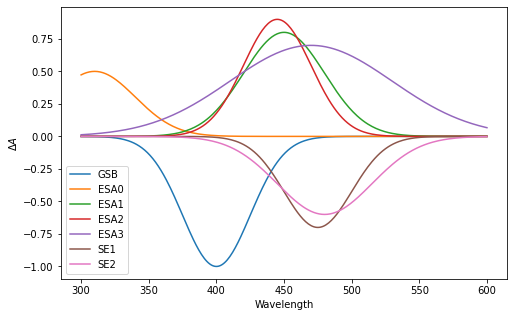

In [1]:
import numpy as np  # import numpy package
import matplotlib.pyplot as plt  # we plot graphs with this library
from matplotlib.ticker import SymmetricalLogLocator, ScalarFormatter, AutoMinorLocator, MultipleLocator, Locator
import warnings
from typing import Union, Iterable

warnings.filterwarnings("ignore")  # get rid of stupid warnings mainly from matplotlib
%matplotlib inline

wavelengths = np.arange(300, 601)  # linear space of wavelengths from 300 to 600 in arbitrary units

# define gaussian function (without a scaling factor) for creating sample spectra
def gauss(x: Union[int, float, np.ndarray], mu: Union[int, float, np.ndarray], 
          sigma: Union[int, float, np.ndarray]) -> np.ndarray:
    """Calculates the Gaussian function, without the scaling factor.
    
    Parameters
    ----------
    x : 
        Dependent variable.
    mu : 
        The position of the Gagussian
    sigma : 
        The width of the Gaussain.
    """
    return np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))

GSB = -gauss(wavelengths, 400, 25)  # ground state bleach
ESA0 = 0.5 * gauss(wavelengths, 310, 30)  # excited state absorption band 0
ESA1 = 0.8 * gauss(wavelengths, 450, 30)  # excited state absorption band 1
ESA2 = 0.9 * gauss(wavelengths, 445, 25)  # excited state absorption band 2
ESA3 = 0.7 * gauss(wavelengths, 470, 60)  # excited state absorption band 3
SE1 = -0.7 * gauss(wavelengths, 475, 25)  # stimulated emission 1
SE2 = -0.6 * gauss(wavelengths, 480, 35)  # stimulated emission 2

# plot individual bands
plt.rcParams['figure.figsize'] = [8, 5]

plt.plot(wavelengths, GSB, label='GSB')
plt.plot(wavelengths, ESA0, label='ESA0')
plt.plot(wavelengths, ESA1, label='ESA1')
plt.plot(wavelengths, ESA2, label='ESA2')
plt.plot(wavelengths, ESA3, label='ESA3')
plt.plot(wavelengths, SE1, label='SE1')
plt.plot(wavelengths, SE2, label='SE2')

plt.xlabel('Wavelength')
plt.ylabel('$\Delta A$')
plt.legend()
plt.show()

### Create and Plot the Species

First species would consist of GSB, ESA1, SE1 and ESA0 bands, which could be unrelaxed singlet state. The other is relaxed singlet state so the spectrum is very similar. The last species is different state, e.g. triplet state. Note that individual bands cannot be resolved in TS measurements. Only their sum is observed.

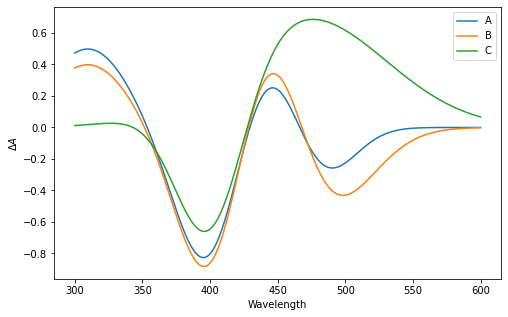

In [32]:
n_w = wavelengths.shape[0]  # dimensions of wavelenths vector
k = 3  # number of species

# define a spectra matrix with dimensions n_w x k of 64 bit float
S = np.empty((n_w, k), dtype=np.float64)  

S[:, 0] = GSB + ESA1 + SE1 + ESA0
S[:, 1] = GSB + ESA2 + SE2 + 0.8 * ESA0
S[:, 2] = GSB + ESA3

def plot_spectra(S: np.ndarray, n_species: int = 3):
    species = list('ABCDEFG')
    
    # plot created spectra
    plt.rcParams['figure.figsize'] = [8, 5]
    for i in range(n_species):
        plt.plot(wavelengths, S[:, i], label=species[i])
    for i in range(n_species, S.shape[1]):  # will be used later...
        plt.plot(wavelengths, S[:, i], label=f'Artifact {i - n_species + 1}', ls='--', lw=1)
    plt.xlabel('Wavelength')
    plt.ylabel('$\Delta A$')
    plt.legend()
    plt.show()

plot_spectra(S)

## Create a Kinetic Model

Typically, species undergoe first order kinetics. The higher orders are observed in longer times (nanosecond timescale) where bimolecular processes can occur. Often, the observed kinetics is non-exponential due to some vibrational and solvation relaxation processes which causes the spectra or stimulated emission to shift, therefore the first order kinetic model is only approximation and such data can be fitted with the usage of more species. 

We will use evolution model, which means that the kinetics starts with species A, then goes to B and then from B to C and then decays to zero. Generally, the time evolution can be described by the following matrix differential equation:

$$\frac{\mathrm{d}\bf{c}}{\mathrm{d}t} = \mathbf{Kc} +  i(t)\mathbf{j} $$
where $$\mathbf c=
\begin{pmatrix}
     c_A(t) \\
     c_B(t)  \\
     c_C(t) 
\end{pmatrix}
$$ is concetration vector in our case and consits only from three species and 
$$\mathbf j=
\begin{pmatrix}
     1 \\
     0  \\
     0  \\
\end{pmatrix}
$$
 is initial population vector. The $$\mathbf K=
\begin{bmatrix}
     -k_{A} & 0  & 0  \\
     k_{A} & -k_{B} & 0 \\
     0  & k_{B} & -k_{C}\\
\end{bmatrix}
$$ is a transfer matrix that describes evolution kinetic model. Species are connected with individal rate constants. The $i(t)$ represents the instrument response function and determines the time resolution of the system. Usually it is approximated as gaussian $$i(t, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}\exp\left(-\frac{(t - \mu)^2}{2\sigma^2}\right) = \frac{1}{\tilde\Delta \sqrt{\pi}}\exp\left(-\frac{(t - \mu)^2}{\tilde\Delta^2}\right)$$ where $\tilde\Delta = \sqrt2 \sigma = \frac{\Delta}{2\sqrt{\ln2}} $ is the Gaussian width and $\Delta$ is FWHM (full width at half maximum) of the Gaussian. Experimentally it is given by convolution of pump and probe pulses. 

General solution of the matrix differential equation is $\mathbf c(t) = e^{\mathbf Kt} * i(t)\mathbf j$ where $*$ denotes [convolution](https://en.wikipedia.org/wiki/Convolution). This is however not very usefull for efficient simulation, because the matrix exponential is very expensive operation. It can be simplified if we diagonalize the matrix $\mathbf K$. Then the matrix exponential is trivial. $\mathbf K$ can be diagonalized by eigenvalue eigenvector decomposition $\mathbf K = \mathbf{U\Lambda U^{-1}}$. Then the general solution is 

$$ \mathbf{A_{II}^T} = \mathbf U \mathrm{diag}(\mathbf{U^{-1}j}) $$
and $$\mathbf c(t) = \big(\exp\left(-\mathrm{diag}(\mathbf \Lambda)t\right) * i(t)\big)  \mathbf{A_{II}}$$

Exponentials convoluted with a gaussian will be called folded exponential and are defined as 
$$c_i(t) = e^{-kt}\theta(t)*i(t) = \frac12 e^{k\left(\frac{k \tilde\Delta^2}{4} - (t - \mu)\right)}\mathrm{erfc}\left(\frac{k \tilde\Delta}{2} - \frac{t - \mu}{ \tilde\Delta}\right)$$

where $\theta(t)$ is Heaviside step function and $\mathrm{erfc}$ is complementary error function. Derivation of this expression is described in `convolve.ipynb`.

This basically means that an arbitrary kinetics model is a linear combination of basis of folded exponential functions that uses the negative eigenvalues of the transfer matrix as an arguments.

For detailed derivation and explanation of kinetic model, see van Stokkum, I. H. M., Larsen, D. S., & van Grondelle, R. (**2004**). Global and target analysis of time-resolved spectra. *Biochimica et Biophysica Acta (BBA) - Bioenergetics*, *1657(2–3)*, 82–104. https://doi.org/10.1016/j.bbabio.2004.04.011
or Joseph S. Beckwith, Christopher A. Rumble & Eric Vauthey (**2020**) *Data analysis in transient electronic spectroscopy – an experimentalist's view*, International Reviews in Physical Chemistry, 39:2, 135-216, https://doi.org/10.1080/0144235X.2020.1757942


In [3]:
# linear + logspace of times -1 to 1000 in arbitrary units
times = np.concatenate((np.linspace(-1, 1, 200, endpoint=False), np.logspace(0, 3, 200)))  

n_t = times.shape[0]  # dimensions of times vector

# show some time points
print(f'Dimensions of times vector: {times.shape}')
times[::4]  # show every forth time point

Dimensions of times vector: (400,)


array([-1.00000000e+00, -9.60000000e-01, -9.20000000e-01, -8.80000000e-01,
       -8.40000000e-01, -8.00000000e-01, -7.60000000e-01, -7.20000000e-01,
       -6.80000000e-01, -6.40000000e-01, -6.00000000e-01, -5.60000000e-01,
       -5.20000000e-01, -4.80000000e-01, -4.40000000e-01, -4.00000000e-01,
       -3.60000000e-01, -3.20000000e-01, -2.80000000e-01, -2.40000000e-01,
       -2.00000000e-01, -1.60000000e-01, -1.20000000e-01, -8.00000000e-02,
       -4.00000000e-02,  0.00000000e+00,  4.00000000e-02,  8.00000000e-02,
        1.20000000e-01,  1.60000000e-01,  2.00000000e-01,  2.40000000e-01,
        2.80000000e-01,  3.20000000e-01,  3.60000000e-01,  4.00000000e-01,
        4.40000000e-01,  4.80000000e-01,  5.20000000e-01,  5.60000000e-01,
        6.00000000e-01,  6.40000000e-01,  6.80000000e-01,  7.20000000e-01,
        7.60000000e-01,  8.00000000e-01,  8.40000000e-01,  8.80000000e-01,
        9.20000000e-01,  9.60000000e-01,  1.00000000e+00,  1.14895100e+00,
        1.32008840e+00,  

### Functions for Simulation of Kinetics

In [4]:
from numpy.linalg import eig, inv
from numba import vectorize  # use numba here to speed-up calculations, https://numba.pydata.org/numba-doc/latest/user/vectorize.html
from math import erfc

# creates and compiles a vectorized function, will work on numpy arrays
@vectorize(nopython=True)  
def fold_exp(t: Union[int, float, np.ndarray], k: Union[int, float, np.ndarray], fwhm: Union[int, float, np.ndarray] = 0) -> np.ndarray:
    """Calculates the folded exponential function, that is the exponential convoluted
    with a gaussian function.
    
    Parameters
    ----------
    t : 
        Time points.
    k : 
        Rate constant(s).
    fwhm : 
        Full Width at Half Maximum.
    """
    
    w = fwhm / (2 * np.sqrt(np.log(2)))  # calcualte Gaussian width = Delta with tilde

    if w > 0:
        return 0.5 * np.exp(k * (k * w * w / 4.0 - t)) * erfc(w * k / 2.0 - t / w)  # calculate the folded exponential if width > 0
    else:
        return np.exp(-t * k) if t >= 0 else 0  # normal exponential if fwhm = 0, but for t < 0, values must be zero (the heaviside function)

def simulate_C(t: np.ndarray, K: np.ndarray, j: np.ndarray, fwhm: Union[int, float, np.ndarray] = 0) -> np.ndarray:
    """Simulates the concentration profiles for a given transfer matrix.
    
    Parameters
    ----------
    t : 
        Time points.
    K : 
        Transfer matrix.
    j :
        Initial population vector.
    fwhm : 
        Full Width at Half Maximum. Number or a vector.
    """
    
    Lambda, U = eig(K)  # get eigenvalues and eigenvectors of K
    U_inv = inv(U)  # calculate the inverse of U

    # calculate A_II^T matrix
    A_II_T = U * U_inv.dot(j)  # U @ diag(U^-1 @ j)
    
    # calculate basis of folded exponentials
    C = fold_exp(t[:, None], -Lambda[None, :], fwhm)
    
    # make linar combination of folded exponentials
    return C.dot(A_II_T.T)  # C @ A_II

### Rate Constants and Model Simulation

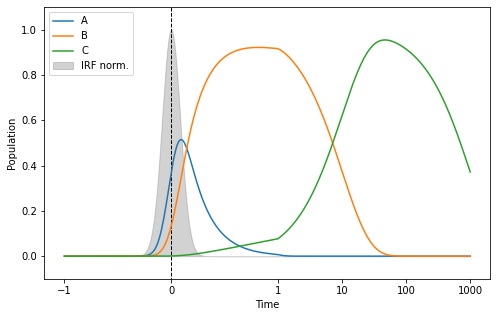

In [5]:
taus = np.asarray([0.2, 10, 1e3])  # lifetimes
ks = 1 / taus  # rate constants

K = np.zeros((k, k))  # transfer matrix
# fill the rate constants as sequential model
for i in range(k):
    K[i, i] = -ks[i]
    if i < k - 1:
        K[i + 1, i] = ks[i]

j = np.zeros(k)  # define the j vector
j[0] = 1

fwhm = 0.2  # use FWHM as 0.2
C = simulate_C(times, K, j, fwhm)

# simulate the Guassian irf normallized
irf = gauss(times, 0, fwhm / (2 * np.sqrt(2 * np.log(2))))

# plot computed concentrations with symlog scale
plt.rcParams['figure.figsize'] = [8, 5]
for i in range(k):
    plt.plot(times, C[:, i], label=species[i])
plt.fill_between(times, irf, 0, color='gray', alpha=0.35, zorder=-10, label='IRF norm.')
plt.xlabel('Time')
plt.ylabel('Population')
plt.xscale('symlog', linthresh=1, linscale=1.5)
plt.ylim(-0.1, 1.1)
plt.vlines(0, -5, 5, color='k', ls='--', lw=1)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.legend()
plt.show()

## Generate the Transient-Absorption (TA) Data

Now, we have spectra and concentration profiles, so it is very easy to generate the data matrix.


In [6]:
D = C @ S.T  # matrix multiply
print(f'Dimensions of matrix D: {D.shape}')
D

Dimensions of matrix D: (400, 301)


array([[ 1.24576828e-32,  1.25884482e-32,  1.27062348e-32, ...,
        -1.80657478e-36, -1.63507246e-36, -1.47879815e-36],
       [ 4.99760208e-32,  5.05006071e-32,  5.09731269e-32, ...,
        -7.31501544e-36, -6.62056604e-36, -5.98775968e-36],
       [ 1.97745861e-31,  1.99821550e-31,  2.01691222e-31, ...,
        -2.92167768e-35, -2.64430078e-35, -2.39153801e-35],
       ...,
       [ 4.89210148e-03,  5.11136516e-03,  5.33709740e-03, ...,
         2.85839318e-02,  2.75816388e-02,  2.66070993e-02],
       [ 4.73352013e-03,  4.94567621e-03,  5.16409116e-03, ...,
         2.76573610e-02,  2.66875582e-02,  2.57446091e-02],
       [ 4.57475143e-03,  4.77979150e-03,  4.99088052e-03, ...,
         2.67296955e-02,  2.57924211e-02,  2.48810998e-02]])

### Plot the Matrix as Heatmap


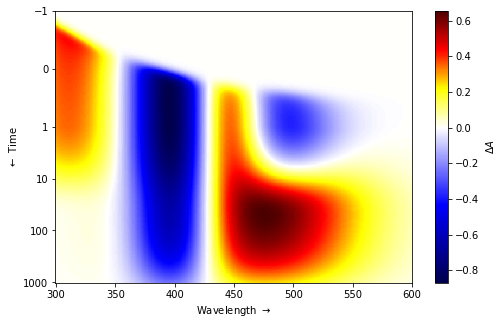

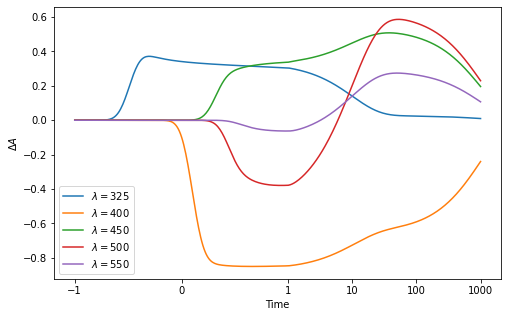

In [40]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def register_div_cmap(zmin: Union[int, float], zmax: Union[int, float]):  # colors for femto TA heat maps: dark blue, blue, white, yellow, red, dark red
    """Registers the diverging colormap suited for the data. Zero values will always be plotted in white color.
    
    Parameters
    ----------
    zmin : 
        Minimal z value.
    zmax : 
        Maximal z value.
    """

    diff = zmax - zmin
    w = np.abs(zmin / diff)  # white color point set to zero z value

    _cdict = {'red': ((0.0, 0.0, 0.0),
                      (w / 2, 0.0, 0.0),
                      (w, 1.0, 1.0),
                      (w + (1 - w) / 3, 1.0, 1.0),
                      (w + (1 - w) * 2 / 3, 1.0, 1.0),
                      (1.0, 0.3, 0.3)),

              'green': ((0.0, 0, 0),
                        (w / 2, 0.0, 0.0),
                        (w, 1.0, 1.0),
                        (w + (1 - w) / 3, 1.0, 1.0),
                        (w + (1 - w) * 2 / 3, 0.0, 0.0),
                        (1.0, 0.0, 0.0)),

              'blue': ((0.0, 0.3, 0.3),
                       (w / 2, 1.0, 1.0),
                       (w, 1.0, 1.0),
                       (w + (1 - w) / 3, 0.0, 0.0),
                       (w + (1 - w) * 2 / 3, 0.0, 0.0),
                       (1.0, 0.0, 0.0))
              }

    custom_cmap = LinearSegmentedColormap('diverging', _cdict)
    cm.register_cmap('diverging', custom_cmap)
    
    
def plot_matrix(times: np.ndarray, wavelengths: np.ndarray, D: np.ndarray, mu: Union[None, np.ndarray] = None, zlim=(None, None)):
    """Plots the data matrix as heat map.
    
    Parameters
    ----------
    times : 
        Array of time points.
    wavelengths : 
        Array of wavelengths.
    D :
        Matrix to plot.
    mu :
        Optional array describing the chirp. If provided, chirp will be plotted.
    zlim :
         Optional limits for the z axis.
    """
    
    zmin, zmax = zlim[0] if zlim[0] is not None else D.min(), zlim[1] if zlim[1] is not None else D.max()
    
    register_div_cmap(zmin, zmax)
    
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
    
    # for plotting of the chirp, see later text
    if mu is not None:
        plt.plot(wavelengths, mu, ls='--', color='k')
    
    plt.pcolormesh(x, y, D, cmap='diverging', shading='auto', vmin=zmin, vmax=zmax)
    plt.colorbar(label='$\Delta A$')
    plt.xlabel('Wavelength $\\rightarrow$')
    plt.ylabel('$\\leftarrow$ Time ')
    plt.gca().invert_yaxis()
    plt.yscale('symlog', linthresh=1, linscale=1)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.show()
    
# plot some traces
def plot_traces(times: np.ndarray, wavelengths: np.ndarray, D: np.ndarray, idxs: Iterable = (25, 100, 150, 200, 250)):
    """Plots the traces at selected indexes of wavelengths array.
    
    Parameters
    ----------
    times : 
        Array of time points.
    wavelengths : 
        Array of wavelengths.
    D :
        Matrix to plot.
    idxs :
         Indexes in wavelengths array to plot.
    """
    for i in (idxs):
        plt.plot(times, D[:, i], label=f'$\\lambda = {i + wavelengths[0]}$')
    plt.xlabel('Time')
    plt.ylabel('$\\Delta A$')
    plt.xscale('symlog', linthresh=1, linscale=1.5)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.legend()
    plt.show()
    

    
plot_matrix(times, wavelengths, D)
plot_traces(times, wavelengths, D)

## Addition of Chirp (Group Velocity Dispersion)

Because speed of light in the measured medium is dependent on the wavelength, blue fotons will hit the detector earlier than the red photons. This causes the chirp and the beginning of the signal is shifted. The chirp can be described as a polynomial (as is in software [GloTarAn](https://glotaran.org/), [pyGloTarAn](https://github.com/glotaran/pyglotaran) or [Optimus](https://optimusfit.org/index.php)) and this function defines the real time zero for each wavelength in terms of original experimental time points:

$$\mu(\lambda) = \sum_{i=0}^{m}\mu_i\left(\frac{\lambda - \lambda_c}{100}\right)^i$$

where $m$ is the order of the polynomial, $\mu_i$ are the polynomial coefficients and $\lambda_c$ is the "central wave" which is the arbitrary parameter to be chosen. Then $\mu_0 = \mu(\lambda_c)$, so the first parameter defines the time zero at central wave. The $100^i$ in the denominator is there to keep all the polynomial coefficients in a similar order. It would cause severe problems in fitting in case this scaling coefficient would not be there.

Addition of chirp complicates stuff. Now we cannot use concentration matrix to represent concentration profiles, but instead, the concentration matrix will be defined for each wavelength, because time zero is always different. So we have to define concentration tensor. The dimensions were ($n_t, k$) and will now be ($n_w, n_t, k$). Also the simple matrix multiply to get the data matrix is no longer valid. We have to use **batched matrix vector multiplication**. In numpy, there is usefull `np.matmul` function for this. So, the each column of $\mathbf D[:, i] =  \mathbf C[i, :, :] \times  \mathbf S[i, :]$. So in other words $$d_{ij} = \sum_{l=0}^{k-1} c_{jil}s_{jl}$$



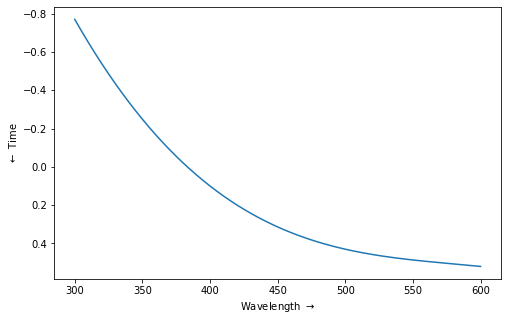

In [43]:
def get_parx(wavelengths: np.ndarray, params: np.ndarray, lambda_c: float = 400.0):
    polynomial = np.ones(wavelengths.shape[0], dtype=np.float64) * params[0]
    
    for i in range(1, len(params)):
        polynomial += params[i] * ((wavelengths - lambda_c) / 100) ** i
    
    return polynomial

# central wave
lambda_c = 400
# polynomial coefficients
parmu = np.asarray([0.1, 0.55, -0.27, 0.05])

mu = get_parx(wavelengths, parmu, lambda_c)

# plot chirp
plt.plot(wavelengths, mu)
plt.gca().invert_yaxis()
plt.xlabel('Wavelength $\\rightarrow$')
plt.ylabel('$\\leftarrow$ Time ')
plt.show()   

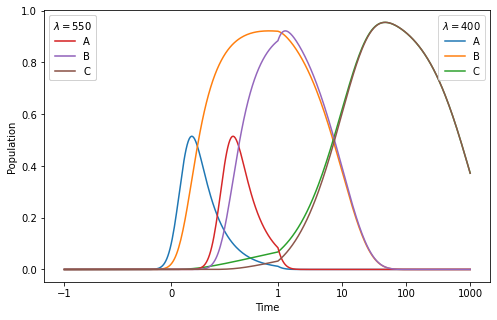

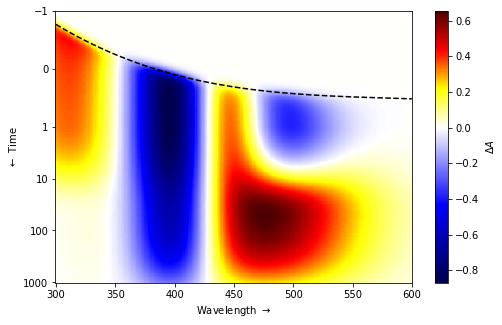

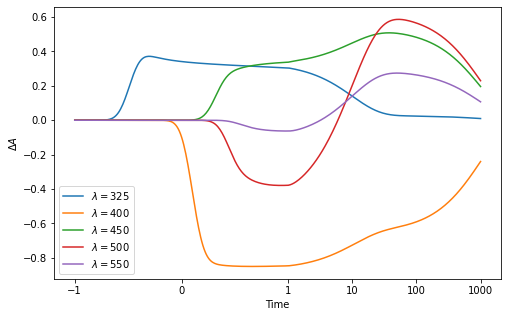

In [103]:
# we need to modify the function for simulation of concentration profiles
def simulate_C(t: np.ndarray, K: np.ndarray, j: np.ndarray, 
               fwhm: Union[int, float, np.ndarray] = 0, mu: Union[None, np.ndarray] = None) -> np.ndarray:
    """Simulates the concentration profiles for a given transfer matrix.
    
    Parameters
    ----------
    t : 
        Time points.
    K : 
        Transfer matrix.
    j :
        Initial population vector.
    fwhm : 
        Full Width at Half Maximum. Number or a vector.
    mu :
        Array describing the chirp.
    """
    
    Lambda, U = eig(K)  # get eigenvalues and eigenvectors of K
    U_inv = inv(U)  # calculate the inverse of U

    # calculate A_II^T matrix
    A_II_T = U * U_inv.dot(j)  # U @ diag(U^-1 @ j)
    
    # for wavelength-dependent IRF, see further text
    _tau = fwhm[:, None, None] if isinstance(fwhm, np.ndarray) else fwhm
    
    if mu is not None:
        # generate concentration tensor
        C = fold_exp(t[None, :, None] - mu[:, None, None], -Lambda[None, None, :], _tau)
    else:
        # keep the original line if mu is not provided
        C = fold_exp(t[:, None], -Lambda[None, :], _tau)
    
    # make linear combination of folded exponentials
    return C.dot(A_II_T.T)  # C @ A_II, generalizes for multidimensional arrays


def plot_populations(times: np.ndarray, wavelengths: np.ndarray, C: np.ndarray, idxs: Iterable = (100, 250),
                     n_species=3):
    """Plots the data matrix as heat map.
    
    Parameters
    ----------
    times : 
        Array of time points.
    wavelengths : 
        Array of wavelengths.
    C :
         Concentration tensor.
    idxs :
         Indexes in wavelengths to plot.
    """
    
    assert C.ndim == 3
    assert C.shape[0] == wavelengths.shape[0]
    
    species = list('ABCDEFG')
    
    lines = []
    
    for w_idx in idxs:
        group = []
        for i in range(n_species):
            group.append(plt.plot(times, C[w_idx, :, i])[0])
        for i in range(n_species, C.shape[-1]):
            group.append(plt.plot(times, C[w_idx, :, i], ls='--', lw=1)[0])
        lines.append(group)
            
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.xscale('symlog', linthresh=1, linscale=1.5)
#     plt.ylim(-0.1, 1.1)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    labels = species[:n_species] + [f'Artifact {i - n_species + 1}'  for i in range(n_species, C.shape[-1])]
    for i in range(len(lines)):
        leg = plt.legend(lines[i], labels, title=f'$\\lambda = {idxs[i] + wavelengths[0]}$', loc=i+1)
        plt.gca().add_artist(leg)
    plt.show()

# get profiles
C = simulate_C(times, K, j, fwhm, mu)

# multiplication of C (n_w, n_t, k) with S (n_w, k, 1), therefore S matrix needs another dimension
# result is D (n_w, n_t, 1) and the last dimension is removed, then matrix is transposed
D = np.matmul(C, S[..., None]).squeeze().T  # batched matrix vector multiply

plot_populations(times, wavelengths, C)
plot_matrix(times, wavelengths, D, mu) # for fwhm = 0.2
plot_traces(times, wavelengths, D)

## Wavelength-Dependency of the IRF

The time resolution is given by the convolution of pump and probe pulses. It is common that the width of supercontinuum probe is dependent on the wavelenght, so the overall time resolution will also be dependent on wavelength. Similar to chirp, wavelength-dependency of IRF can be described by a polynomial which determines the FWHM at wavelength $\lambda$:

$$\tau(\lambda) = \sum_{i=0}^{m}\tau_i\left(\frac{\lambda - \lambda_c}{100}\right)^i$$

where $m$ is the order of the polynomial, $\tau_i$ are the polynomial coefficients and $\lambda_c$ is the central wave.  Then $\tau_0 = \tau(\lambda_c)$, so the first parameter defines the FWHM at central wave. 


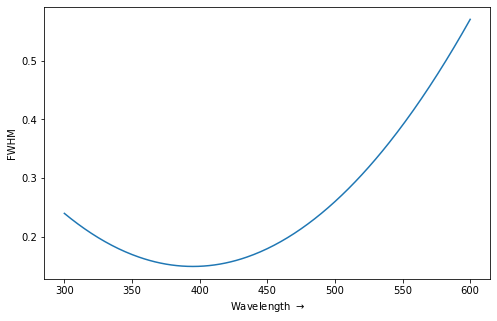

In [70]:
# polynomial coefficients, greatly exagarated
partau = np.asarray([0.15, 0.01, 0.10])

tau = get_parx(wavelengths, partau, lambda_c)

# plot FWHM dependency
plt.plot(wavelengths, tau)
plt.xlabel('Wavelength $\\rightarrow$')
plt.ylabel('FWHM')
plt.show()   

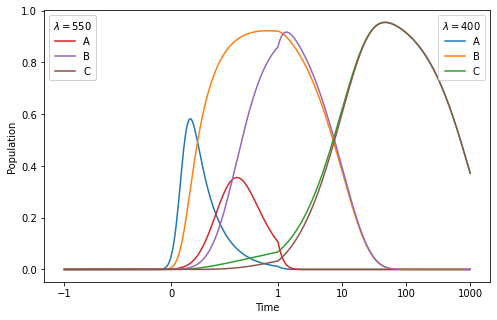

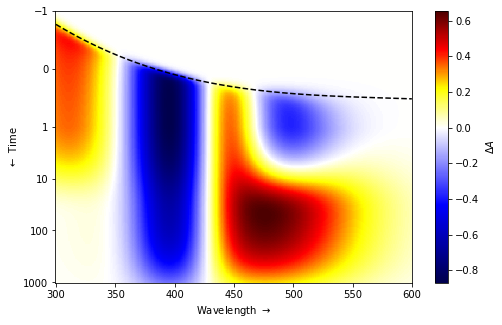

In [104]:
# get profiles, instead of fwhm, use simulated tau, the effect is barely noticable, but at lambda=550, the species A rises slower than that of at lambda=400
C = simulate_C(times, K, j, tau, mu)

# batched matrix vector multiply
D = np.matmul(C, S[..., None]).squeeze().T  

plot_populations(times, wavelengths, C)
plot_matrix(times, wavelengths, D, mu)

## Addition of Coherent Artifacts

Coherent artifacts are the results of overlap of pump and probe pulses in time and space. They includes the cross-phase modulation which is a transient change of the refractive index by high energy pump pulse. As a result, signals appear around the chirp. Other contributions, usually the spike signals arise from stimulated raman scattering from solvent. These signals can be nicely simulated as Gaussian and its derivatives:

\begin{align}
i(t, \mu, \sigma) &= \frac{1}{\sigma \sqrt{2\pi}}\exp\left(-\frac{(t - \mu)^2}{2\sigma^2}\right) \\
i^\prime(t, \mu, \sigma) &= \frac{t - \mu}{\sigma^2} i(t, \mu, \sigma) \\
i^{\prime\prime}(t, \mu, \sigma) &= \left(\frac{(t - \mu) ^ 2}{\sigma^4} - \frac{1}{\sigma ^2}\right) i(t, \mu, \sigma) \\
i^{\prime\prime\prime}(t, \mu, \sigma) &= \left(\frac{(t - \mu) ^ 3}{\sigma^6} - \frac{3(t - \mu)}{\sigma ^4}\right) i(t, \mu, \sigma) 
\end{align}

Coherent artifacts are then simulated analogously to a real signal contributions and then added to the original data. Sigma for Gaussians can be calculated form $\Delta$ (FWHM):

$$\sigma = \frac{\Delta}{2\sqrt{2\ln 2}}$$

For details, follow K. Ekvall, P. van der Meulen, C. Dhollande, L.E. Berg, S. Pommeret, R. Naskrecki and J.C. Mialocq, *J. Appl. Phys.* 87 (5), 2340–2352 (**2000**). https://doi.org/10.1063/1.372185

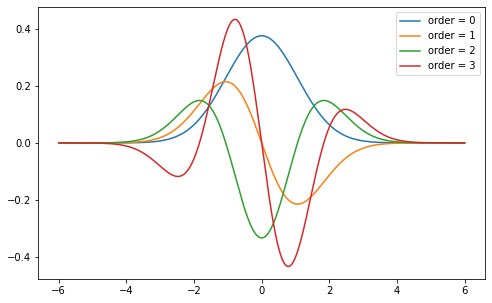

In [105]:
# implementation of artifacts in pyGlotaran is similar https://github.com/glotaran/pyglotaran/blob/2dd249c8c86858847d021c52cac05c193cb1e401/glotaran/builtin/models/kinetic_spectrum/coherent_artifact_megacomplex.py
def gaussian_derivatives(t: np.ndarray, fwhm: Union[int, float, np.ndarray] = 0.2, 
                         mu: Union[int, float, np.ndarray] = 0, normalized: bool = False) -> np.ndarray:
    """Simulates the Gaussian and its first four derivatives.
    
    Parameters
    ----------
    t : 
        Time points.
    fwhm : 
        Full Width at Half Maximum. Number or a vector.
    mu :
        Array describing the chirp.
    normalized: 
        If True, Gaussian functions and its derivatives will be normalized to its maximal value.
    """
    s = fwhm / (2 * np.sqrt(2 * np.log(2)))  # calculate sigma from fwhm
    
    if isinstance(mu, np.ndarray):
        mu = mu[:, None]
        t = t[None, :]
    if isinstance(s, np.ndarray):
        s = s[:, None]
        t = t[None, :] if t.ndim == 1 else t
        
    tt = t - mu    # t - mu
    tt2 = tt * tt  # (t - mu) ^ 2
    s2 = s * s     # square of sigma
    
    g = np.exp(-0.5 * tt2 / s2) / (s * np.sqrt(2 * np.pi))  # Gaussian
    
    g_derivs = np.tile(g, [4] + tt.ndim * [1])  # duplicate the data
    
    g_derivs[1] *= -tt / s2                                           # first derivative
    g_derivs[2] *= ( tt2 / (s2 * s2) - 1 / s2 )                       # second derivative
    g_derivs[3] *= ( tt2 * tt / (s2 * s2 * s2) - 3 * tt / (s2 * s2))  # third derivative
    
    if normalized:
        g_derivs /= g_derivs.max(axis=-1, keepdims=True)  # normalize the data
    
    return g_derivs
    
_t = np.linspace(-6, 6, 1000)
g_derivs = gaussian_derivatives(_t, 2.5, normalized=False)
for i in range(g_derivs.shape[0]):
    plt.plot(_t, g_derivs[i], label=f'order = {i}')

plt.legend()
plt.show() 

### Generate the Coherent Artifacts Spectra

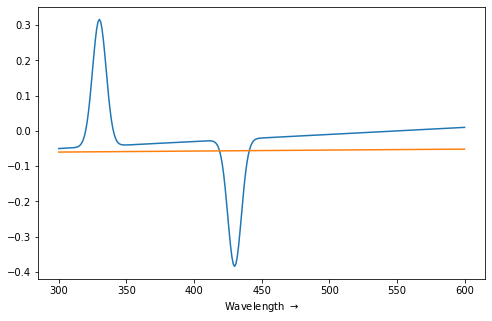

In [109]:
# create a coh-spectra matrix, only 3 derivatives will be used
S_COH = np.zeros((n_w, 2), dtype=np.float64)

# coherent artifacts spectra

# the first artifact with zero order gaussian represents the stimulated Raman scattering signals
S_COH[:, 0] = -0.36 * gauss(wavelengths, 430, 5) + 0.36 * gauss(wavelengths, 330, 5) + (wavelengths - 300) * 0.0002 - 0.05

# next signals simulates the cross-phase modulation
S_COH[:, 1] = -0.06*np.exp(-(wavelengths - 300) * 0.0005)
# S_COH[:, 2] = -0.16*np.exp(-(wavelengths - 300) * 0.009)

# plot the gaussian derivatives
for i in range(S_COH.shape[1]):
    plt.plot(wavelengths, S_COH[:, i])

plt.xlabel('Wavelength $\\rightarrow$')
plt.show()

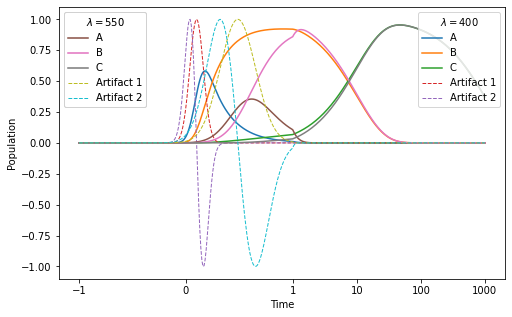

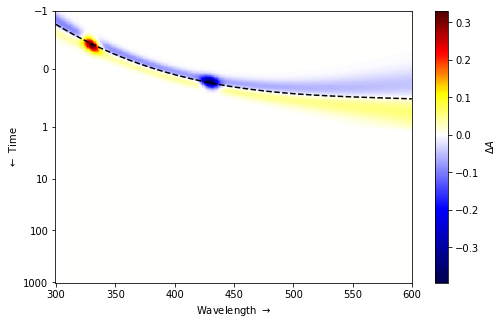

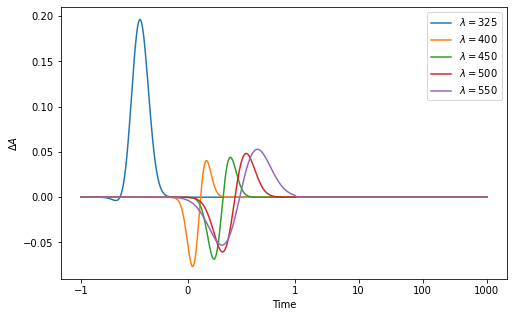

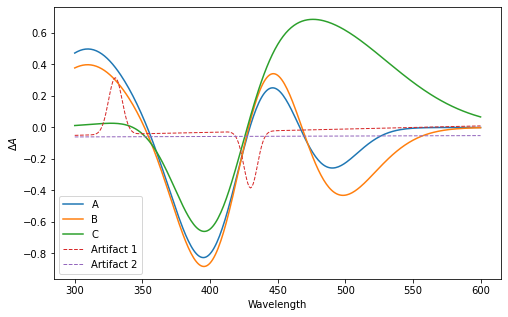

In [112]:
# simulate artifacts, including the chirp and plot the matrix
C = simulate_C(times, K, j, tau, mu)
C_COH = gaussian_derivatives(times, tau, mu, normalized=True)[:-2, ...]  # remove the last derivative
C_COH = C_COH.transpose(1, 2, 0)  # transpose dimensions for batch matrix vector multiplication

C_full = np.concatenate((C, C_COH), axis=-1)  # combine traces and artifacts
S_full = np.concatenate((S, S_COH), axis=-1)

D_COH = np.matmul(C_COH, S_COH[..., None]).squeeze().T  

plot_populations(times, wavelengths, C_full, idxs=(100, 250))

plot_matrix(times, wavelengths, D_COH, mu)
plot_traces(times, wavelengths, D_COH)
plot_spectra(S_full)

### Combine Both Datasets

True


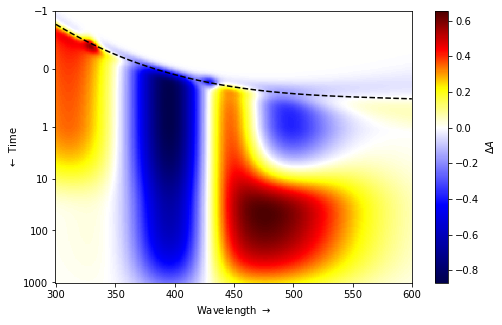

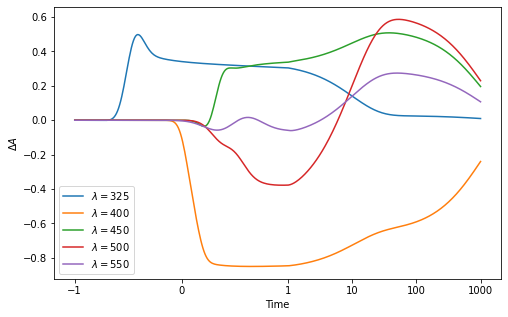

In [116]:
# add the simulated data and coherent artifacts together
D_full = D + D_COH
D_full_sep = np.matmul(C_full, S_full[..., None]).squeeze().T  

print(np.allclose(D_full, D_full_sep))

plot_matrix(times, wavelengths, D_full, mu)
plot_traces(times, wavelengths, D_full)

## Addition of Noise

As the change of absorption is calculated from light intensities of supercontinuum probe before and after excitation, the transient absrption data will exhibits noise modulated by the the spectrum of the probe pulse. In regions where the intensity of the probe is low, the noise will have stronger impact on the resulting signal. This is simulated in the following code. Also in case of high differential absorption, the noise will also be greatly increased. Though, the additional noise in the fs-TA spectra mostly come from unstable laser intensity over the entire measurement, which causes the individual spectra to have different absorbance. This effect is not simulated here.

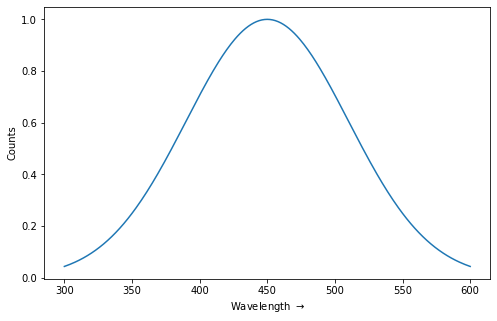

In [16]:
white = gauss(wavelengths, 450, 60)  # white supercontinuum probe simplified as Gaussian
plt.plot(wavelengths, white)
plt.xlabel('Wavelength $\\rightarrow$')
plt.ylabel('Counts')
plt.show()

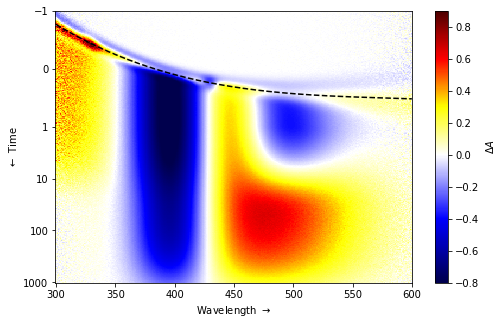

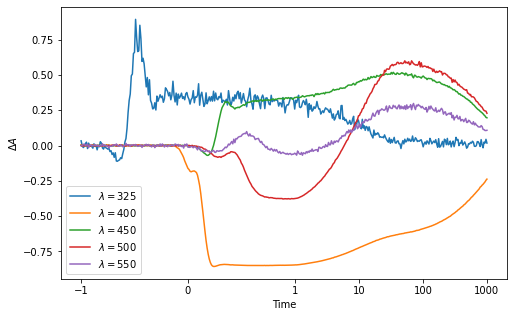

In [17]:
T = 10 ** (-D_full)  # calculate change of transmittance
I = white * T  # intensity of light after pump
I_noise = np.random.normal(I, scale=0.004)  # addition of gaussian noise to the light intesity

# recalculate to differential absorbtion, if noise is too high, it can result in < 0 transmittance therefore giving nan values as absorbances
D_noise = -np.log10(I_noise/white)

plot_matrix(times, wavelengths, D_noise, mu, zlim=(-0.8, 0.9))
plot_traces(times, wavelengths, D_noise)

## Fitting

The aim is to extract the rate constants and the spectra of the invidiual species. Extracted spectra depends on the kinetic model used and many kinetic models will equivalent. It means that all these models will fit the data equally well, providing same or different rate constants and spectra. E.g. Sequential model that gives Evolution-Associated Difference Spectra (EADS) is equivalent to parallel model which provides Decay-Associated Difference Spectra (DADS). Both models will fit the same rate constants. In other words, the EADS are linear combination of DADS. The same is true for concentration profiles as was discussed earlier.

Fitting in classical non-chirped data consist of finding such rate constants for a given model which gave the minimal sum of squares of residuals.

$$\min_{\mathbf\Theta}  \vert\vert\mathbf{D_{data} - D_{fit}(\Theta)}\vert\vert^2$$

where $\mathbf\Theta = (p_1, p_2, \dots, p_n)$ is the vector of parameters to optimize, $\mathbf{D_{fit}}$ are the simulated data and $\mathbf{D_{data}}$ are the recorded data. As the kinetic parametes are calculated from exponential functions and other non-linear equations, the fitting can be achieved only iteratively using some convenient minimizing algorithm. Usefull modern algorithm is Trust Region Reflective (TRF) algorithm. TRF is implemented in [Python (SciPy)](https://github.com/scipy/scipy/blob/master/scipy/optimize/_lsq/trf.py).

In matrix method for global analysis (see page 169 of [Data analysis in transient electronic spectroscopy](https://doi.org/10.1080/0144235X.2020.1757942))

### Variable Projection

For matrix-version Beer Lambert law (no wavelength dependency for now) $\mathbf{D_{fit}}$ is made by multiplying concentration and spectra matrix in which the concentration matrix is parametrized and spectra matrix represent linear parameters to be determined by the fit. So variable projection is suited for minimizing function composed of linear combination of non-linear functions.  $$\mathbf{D_{fit}} = \mathbf{C(\Theta)S^T}$$ Least squares estimation of spectra matrix is straighforward: $$\mathbf{S^T} = \mathbf{C(\Theta)^+D_{data}}$$ where $\mathbf{C^+}$ is Moore-Penrose Pseudoinverse that solves the overdetermined least squares problem. We can put this expression back into the minimizing problem equation: 

$$\min_{\mathbf\Theta}  \vert\vert\mathbf{D_{data} - C(\Theta)C(\Theta)^+D_{data}}\vert\vert^2 = \min_{\mathbf\Theta}  \vert\vert\left(\mathbf{I - C(\Theta)C(\Theta)^+}\right)\mathbf{D_{data}}\vert\vert^2$$

Expression in a round brackets is called variable projection functional $V_p$. Pseudoinverse can be efficiently calculated by matrix decomposition methods, e.g. by [QR](https://en.wikipedia.org/wiki/QR_decomposition) or [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) (Singular Value Decomposition). SVD derivation is shown here. Matrix $\mathbf A = \mathbf{U\Sigma V^T}$ can be decomposed to left ($\mathbf U$) and right ($\mathbf V$) singular vectors, scaled by singular values contained in the diagonal matrix $\mathbf\Sigma$, sorted from largest to lowest. $\mathbf U$ and $\mathbf V$ matrices are orthonormal, so $\mathbf{V^{-1}V = V^TV = I = U^TU = U^{-1}U}$. Pseudoinverse of $\mathbf A$ can be efficiently calculated by SVD:

$$\mathbf{A^+} = \mathbf{(A^TA)^{-1}A^T} = \mathbf{V \Sigma^{-1} U^T}$$

Inverse of diagonal $\mathbf\Sigma$ matrix is just inverting values on main diagonal. Using this for variable projection functional, we get $$V_p = \left(\mathbf{I - C(\Theta)C(\Theta)^+}\right)\mathbf{D_{data}} = \left(\mathbf{I - U(\Theta)U(\Theta)^T}\right)\mathbf{D_{data}}$$ where $\mathbf{U(\Theta)}$ are left singular vectors obtained from SVD of $\mathbf{C(\Theta)}$ matrix. Due to numerial errors, it is important to remove vectors that corresponds to small singular values (inverting small values leads to very large numbers!). Also, from computational perspective, it is efficient to first compute $\mathbf{U(\Theta)^TD_{data}}$, then multiply the result with $\mathbf{U(\Theta)}$ from left and then finally subtract the result from $\mathbf{D_{data}}$. In the case of wavelength-dependent concetration matrix, that is the concentration tensor, we have to use partitioned variable projection. So, we calculate the SVD of all slices of C tensor for each wavelength (batched SVD). Then, all matrix operations are just batched versions.

Alternative option to VarPro is to use direct solve method, using with [Tikhonov Regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (Ridge regression, to eliminate problems in case of singular matrices). It is presented as `blstsq` and is actually faster than fancy ParVarPro method (`res_parvarpro_svd`). Speed could actually be improved by leveraging some code to GPU. The batched SVD and other matrix operations should be done efficiently on GPU.

In [92]:
# inspiration from https://github.com/Tillsten/skultrafast/blob/9544c3cc3c3c3fa46b728156198807e2b21ba24b/skultrafast/base_funcs/pytorch_fitter.py
def blstsq(A: np.ndarray, B: np.ndarray, alpha: float = 1e-10):
    """
    Batched linear least-squares by numpy with direct solve method with optional Tikhonov regularization
    to prevent errors in case of singular matrices.
    Minimizes sum ||A_i x_i - B_i||_2^2 + alpha||Ix||_2^2 for x, where A is a tensor (L, M, N), B is matrix (L, M)

    Parameters
    ----------
        A : shape(L, M, N)
        B : shape(L, M)
        alpha: float

    Returns
    -------
        tuple of (coefficients.T, fit.T)
    """

    # https://en.wikipedia.org/wiki/Tikhonov_regularization
    # (A^T A + alpha*I) X = A^T B, solve for X

    AT = np.transpose(A, (0, 2, 1))  # transpose of A
    ATA = np.matmul(AT, A)  # A.T @ A
    ATB = np.matmul(AT, B[..., None])  # A.T @ B

    if alpha != 0:
        I = alpha * np.eye(ATA.shape[-1])  # alpha * identity matrix
        ATA += I[None, ...]  # add to ATA, TODO, speed could be improved here, possibly numba...

    X = np.linalg.solve(ATA, ATB)  # solve batched linear system of equations

    fit = np.matmul(A, X).squeeze().T

    return X.squeeze().T, fit

# caluclates the residuals with partitioned variable projection
def parvarpro_svd(C: np.ndarray, D: np.ndarray, rcond: float = 1e-10):
    """Calculates residuals efficiently  by partitioned variable projection.
    residuals are (I - CC+)D. C is tensor (n_w, n_t, k), D is matrix (n_t, n_w)
    Projector CC+ is calculated by batched svd
    """
    U, S, VT = np.linalg.svd(C, full_matrices=False)  # calculate batch svd of C tensor
    cutoff = rcond * np.max(S, axis=-1, keepdims=True)
    small = S < cutoff
    small = np.tile(small[:, None, :], [1, U.shape[1], 1])
    U[small] = 0  # set vector with small singular values to zero

    UT = np.transpose(U, (0, 2, 1))

    UTD = np.matmul(UT, D.T[..., None])
    fit = np.matmul(U, UTD).squeeze().T

    return fit

def simulate_C_with_artifacts(taus: np.ndarray, times: np.ndarray, fwhm: Union[int, float, np.ndarray] = 0,
                              mu: Union[None, np.ndarray] = None, n_derivatives=2):
    """Simulates the sequential model with artifacts as  gaussian and its derivatives."""
    k = taus.shape[0]
    ks = 1 / taus  # rate constants

    K = np.zeros((k, k))  # transfer matrix
    # fill the rate constants as sequential model
    for i in range(k):
        K[i, i] = -ks[i]
        if i < k - 1:
            K[i + 1, i] = ks[i]

    j = np.zeros(k)  # define the j vector
    j[0] = 1

    C = simulate_C(times, K, j, fwhm, mu)
    C_COH = gaussian_derivatives(times, tau, fwhm, normalized=True)[:n_derivatives + 1, ...]
    C_COH = C_COH.transpose(1, 2, 0)  # transpose dimensions

    C_tensor = np.concatenate((C, C_COH), axis=-1)  # combine traces and artifacts
    
    return np.nan_to_num(C_tensor)

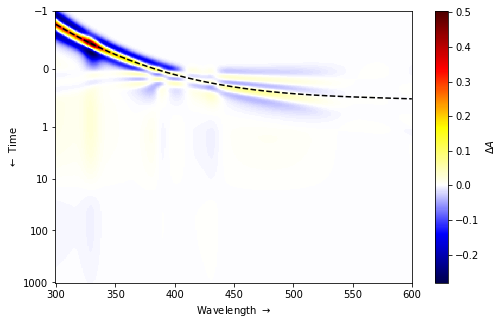

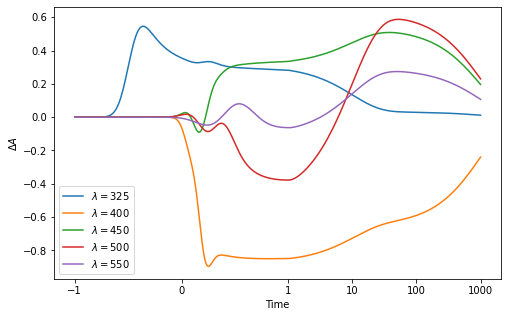

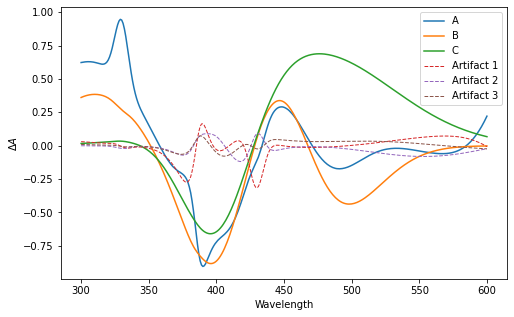

In [95]:
from lmfit import Parameters, report_fit, Minimizer

# setup the fitting parameters
params = Parameters()

# used parmu = [0.1, 0.55, -0.27, 0.05]
# parmu coefficients
params.add('parmu_0', value=0.1, min=-np.inf, max=np.inf, vary=True)
params.add('parmu_1', value=0.55, min=-np.inf, max=np.inf, vary=True)
params.add('parmu_2', value=-0.27, min=-np.inf, max=np.inf, vary=True)
params.add('parmu_3', value=0.05, min=-np.inf, max=np.inf, vary=True)

# used partau = [0.15, 0.01, 0.10]
# partau coefficients
params.add('partau_0', value=0.15, min=-np.inf, max=np.inf, vary=True)
params.add('partau_1', value=0.01, min=-np.inf, max=np.inf, vary=True)
params.add('partau_2', value=0.1, min=-np.inf, max=np.inf, vary=True)

# used kinetic params [0.2, 10, 1e3]
params.add('tau_0', value=0.2, min=0, max=np.inf, vary=True)
params.add('tau_1', value=10, min=0, max=np.inf, vary=True)
params.add('tau_2', value=1e3, min=0, max=np.inf, vary=True)

def get_model_params(params):
    lambda_c = 400
    
    # extract values from parameters
    pars = [par.value for key, par in params.items()]
    
    parmu = np.asarray(pars[:4])
    partau = np.asarray(pars[4:7])
    taus = np.asarray(pars[7:])

    mu = get_parx(wavelengths, parmu, lambda_c)
    tau = get_parx(wavelengths, partau, lambda_c)
    
    return taus, mu, tau


def simulate_model(params):
    taus, mu, tau = get_model_params(params)
    
    C = simulate_C_with_artifacts(taus, times, tau, mu, n_derivatives=2)
    
    ST, D_fit = blstsq(C, D_full.T, 0)  # solve batched least squares problem
    
    return D_fit, ST, mu, tau

    
D_fit, ST_fit, mu_fit, tau_fit = simulate_model(params)
residuals = D_full - D_fit
plot_matrix(times, wavelengths, residuals, mu_fit,)
plot_traces(times, wavelengths, D_fit)
plot_spectra(ST_fit.T)
# plt.plot(wavelengths, tau_fit - tau)
# plt.show()

In [94]:
# define residuals function that will be minimized
def residuals_direct_solve(params):
    taus, mu, tau = get_model_params(params)
    
    C = simulate_C_with_artifacts(taus, times, tau, mu, n_derivatives=2)
    
    _, D_fit = blstsq(C, D_full.T, 0)  # solve batched least squares problem
    
    return D - D_fit

def residuals_parvarpro(params):
    taus, mu, tau = get_model_params(params)
    
    C = simulate_C_with_artifacts(taus, times, tau, mu, n_derivatives=2)
    
    D_fit = parvarpro_svd(C, D_full)
    
    return D - D_fit
    
# benchmark different methods of computation
print("Timing of direct solve method.")
%timeit residuals_direct_solve(params)
print("\nTiming of partitioned variable projection method.")
%timeit residuals_parvarpro(params)

r_ds = residuals_direct_solve(params)
r_pvp = residuals_parvarpro(params)

# residuals solved with different methods are the same
np.allclose(r_ds, r_pvp)

Timing of direct solve method.
37.1 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Timing of partitioned variable projection method.
47 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


True

In [96]:
minimizer = Minimizer(residuals_direct_solve, params, nan_policy='omit')
kwds = dict(jac='3-point', ftol=1e-10, xtol=1e-10, gtol= 1e-10, loss='linear', verbose=2)
result = minimizer.minimize(method='least_squares', **kwds)  # minimize the residuals using TRF algorithm

# report_fit(result)
result.params


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0638e+01                                    1.66e+02    
       1              3         3.4247e+01      6.39e+00       1.00e-01       8.01e+01    
       2              4         2.7853e+01      6.39e+00       2.01e-01       9.11e+01    
       3              5         2.3758e+01      4.09e+00       1.55e+00       9.27e+01    
       4              6         2.1355e+01      2.40e+00       4.02e-01       4.61e+01    
       5              7         2.0465e+01      8.90e-01       8.03e-01       1.18e+01    
       6              8         2.0168e+01      2.96e-01       3.33e-01       1.95e+01    
       7              9         1.9992e+01      1.76e-01       3.49e-01       6.74e+00    
       8             10         1.9859e+01      1.33e-01       4.34e-01       4.73e+00    
       9             11         1.9750e+01      1.09e-01       5.19e-01       3.39e+00    

name,value,standard error,relative error,initial value,min,max,vary
parmu_0,0.11439278,3.1814e-04,(0.28%),0.1,-inf,inf,True
parmu_1,0.53833862,3.1200e-04,(0.06%),0.55,-inf,inf,True
parmu_2,-0.26499296,4.4436e-04,(0.17%),-0.27,-inf,inf,True
parmu_3,0.10252834,2.2881e-05,(0.02%),0.05,-inf,inf,True
partau_0,0.21615234,3.6245e-04,(0.17%),0.15,-inf,inf,True
partau_1,-0.00638900,6.9247e-04,(10.84%),0.01,-inf,inf,True
partau_2,-0.06294006,5.9795e-04,(0.95%),0.1,-inf,inf,True
tau_0,7.90726745,5.35603855,(67.74%),0.2,0.00000000,inf,True
tau_1,7.84461446,5.41581531,(69.04%),10,0.00000000,inf,True
tau_2,1001.16678,1.69612697,(0.17%),1000.0,0.00000000,inf,True


## Fitted spectra

Now, we can see, that both parameters $k_1$ and $k_2$ are basically the same as original parameters that we used to construct the data. We can now plot the found spectra and compare them to gaussian spectra we used to construct the data. Result is really accurate, given the amount of noise, that we added to the data. Here we can appreciate the power of Singular value decomposition.

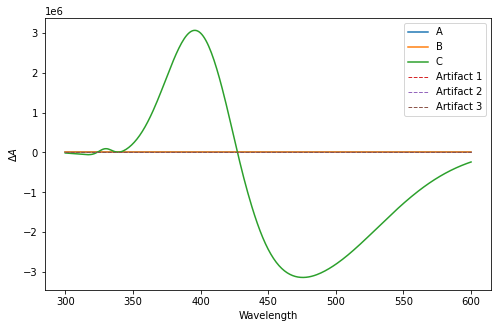

In [89]:
D_fit, ST_fit, mu_fit, tau_fit = simulate_model(result.params)  # simulate model with fitted params

plot_spectra(ST_fit.T)

# for i in range(n):
#     plt.plot(wavelengths, E[i], label=f'Species {i+1}', lw=3)
# for i in range(n):
#     plt.plot(wavelengths, E_guess[i], label='Fit', color=(0, 0, 0, 0.7), lw=2)
# plt.xlabel('Wavelength')
# plt.ylabel('Epsilon $\epsilon$')
# plt.legend()
# plt.show()

## Confidence intervals and correlation between parameters

The error of parameters in fit report are given in the confidence level of $1\sigma$. That is 68.27% probability that the value lies in the interval $\left(\overline{x} - \sigma, \overline{x} + \sigma\right)$, where $\overline{x}$ is the average value. Errors are calculated from the covariance matrix. For modern and correct estimation of confindence intervals, we can use the functions in [lmfit package](https://lmfit.github.io/lmfit-py/confidence.html). Read for more information, but in sumary, in some models (eg. sum of exponentials), estimation of parameter errors from covariance matrix could be wrong. Lmfit package provides function to calculate confidence intervals for these parameters correctly. Also, 2D confidence plot for two parameters is possible. The calculation takes some time, because the parameters are varied and others reoptimized by fitting. This can be really computationaly demanding for complicated models.

The below code prints confidence intervals for $1\sigma$, $2\sigma$ and $3\sigma$. The confidence intervals are symetrical and errors at $1\sigma$ are comparable to that estimated directly from fitting, so the estimation from covarinace matrix is correct and this analysis wouldn't be necessary. The next cell shows 2D correlation of $k_1$ and $k_2$. We can see that it is a nice elipse, so it really behaves normally.

There is also possibility to estimate confidence intervals and correlations by Markov Chain Monte Carlo (MCMC), for that, see the above link to lmfit package.

In [123]:
from lmfit import report_ci, conf_interval

ci = conf_interval(m, result, sigmas=(1, 2, 3))
report_ci(ci)

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k1:  -0.00006  -0.00004  -0.00002   0.01500  +0.00002  +0.00004  +0.00006
 k2:  -0.00004  -0.00002  -0.00001   0.00800  +0.00001  +0.00002  +0.00004


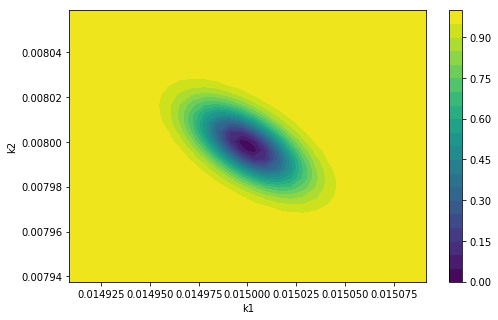

In [124]:
from lmfit import conf_interval2d

def confidence_interval2D(x_name: str, y_name: str, nx: float = 10, ny: float = 10):
    cx, cy, grid = conf_interval2d(m, result, x_name, y_name, nx, ny)
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.contourf(cx, cy, grid, np.linspace(0, 1, 21))
    plt.xlabel(x_name)
    plt.colorbar()
    plt.ylabel(y_name)
    plt.show()

confidence_interval2D('k1', 'k2', 30, 30)

In [126]:
import timeit

%timeit m.minimize(method='leastsq')

22.5 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
